## Term Project

### Fine-Tuning

LLM fine-tuning is a technique to adjust ceratain wights of a LLM to guide it generate tailored response for a specific task without the hassle of training and building a LLM from scratch. Fine tuning requires preparation of the task specific dataset, fine tune the model and then evaluate the performance of the fine-tuned model for qualitative and quantitative metrics.

``` Prepare dataset >> Load dataset to OpenAI >> Start Fine Tuning Job >> Evaluate Metrics >> Run test```

In the assignment, we are fine-tuning Open AI `gpt-4o-mini` model, so that it can perform the specific task of answeing `mental health` questions.

### 1. Prepare Dataset

Open AI fine tuning expects jsonl format with each line containing example with messages similar to [chat completion api format][1] (example below). It is a list of messages where each message has a role, content, and optional name. 

```
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}
```

[1]:https://platform.openai.com/docs/api-reference/chat/createm
[2]:https://github.com/bahree/GenAIBook/tree/main/chapters/ch09/data

In [25]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np
import tiktoken  
import os
import pprint
import time
import pandas as pd
import jsonlines
import json
import re
import unicodedata

In [2]:
# load the raw dataset
df = pd.read_csv("./datasets/20200325_counsel_chat.csv")

In [3]:
# veiw few records
df.head()

,Unnamed: 0,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
0,0,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,"If everyone thinks you're worthless, then mayb...",1,2899,train
1,1,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Robin Landwehr, DBH, LPCC, NCCMental Health in...",https://counselchat.com/therapists/robin-landw...,"Hello, and thank you for your question and see...",1,3514,train
2,2,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Lee KingI use an integrative approach to treat...,https://counselchat.com/therapists/lee-king,First thing I'd suggest is getting the sleep y...,0,5,train
3,3,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Shauntai Davis-YearginPersonalized, private on...",https://counselchat.com/therapists/shauntai-da...,Therapy is essential for those that are feelin...,0,31,train
4,4,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Jordan WhiteLicensed Social Worker at Oak Root...,https://counselchat.com/therapists/jordan-white,I first want to let you know that you are not ...,0,620,train


The dataset have some large text, and in order to keep the cost of fine tuning low the records having very large text will be dropped. Before dropping such text it is better to see the distribution of lengths to make a good estimate on how long text should kept for processing.

In [4]:
def clean_unicode(text):
    regex_uniode_clean = re.sub(u'\xa0', lambda match: "", text)
    return re.sub(f"[\\r\\t\\n]", lambda match: " " , regex_uniode_clean)

In [5]:
#clean unicode chars
df["questionText"] = df["questionText"].apply(clean_unicode)
df["answerText"] = df["answerText"].apply(clean_unicode)

In [6]:
#claculate the length of texts
df["question_length"] = df["questionText"].str.len()
df["answer_length"] = df["answerText"].str.len()

Five point summary of question_length
 count    2129.000000
mean      274.907938
std       233.581561
min        26.000000
25%       147.000000
50%       232.000000
75%       348.000000
max      2702.000000
Name: question_length, dtype: float64


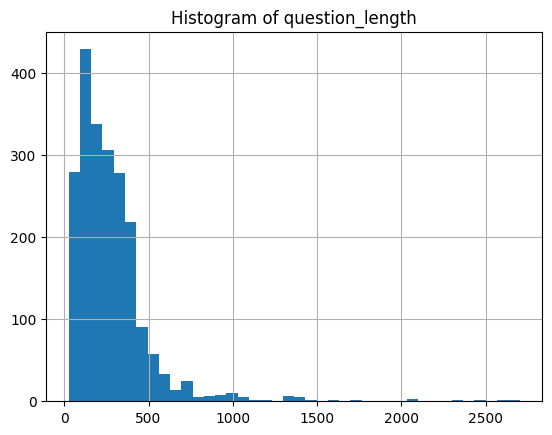

Five point summary of answer_length
 count    2129.000000
mean      970.705026
std       666.556980
min        10.000000
25%       513.000000
50%       800.000000
75%      1225.000000
max      5491.000000
Name: answer_length, dtype: float64


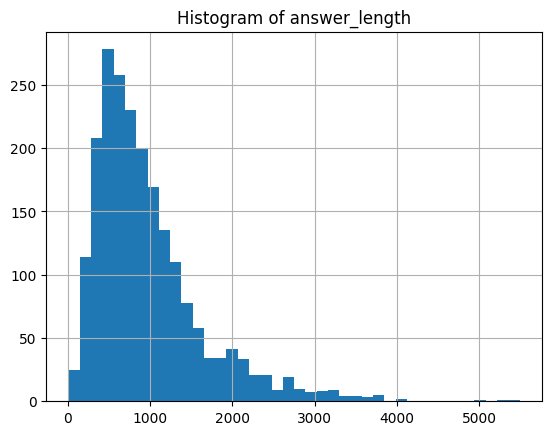

In [7]:
# plot the ditribution of lengths
for cols in ["question_length", "answer_length"]:
    df[cols].hist(bins=40)
    print(f"Five point summary of {cols}\n {df[cols].describe()}")
    plt.title(f"Histogram of {cols}")
    plt.show()

Both the Question and th Response charcter length is heavily right skewed. hence, it will be a good estimate to discard records beyond 1.5IQR of Q3, i.e. Similarly very small responses such as less than $100$ characters may not be good response to the questions. 
```
lower limit: 100
upper limit: Q3 + 1.5IQR

```

In [8]:
# function to drop large text length records
def drop_large_txt_records(df):
    for cols in ["question_length", "answer_length"]:
        q1 = df[cols].quantile(0.25)
        q3 = df[cols].quantile(0.75)
        IQR = q3-q1
        upper_limit = q3 + 1.5*IQR
        print(f"Upper Limit for {cols}: {upper_limit}")
        print(f"Shape before dropping records: {df.shape}")
        df = df.drop(df[df[cols] < 100].index)
        df = df.drop(df[df[cols] > upper_limit].index)
        print(f"Shape after dropping records: {df.shape}")
    return df

In [9]:
df_copy = df.copy()

df_no_outliers = drop_large_txt_records(df_copy)

Upper Limit for question_length: 649.5
Shape before dropping records: (2129, 14)
Shape after dropping records: (1697, 14)
Upper Limit for answer_length: 2283.0
Shape before dropping records: (1697, 14)
Shape after dropping records: (1600, 14)


Five point summary of question_length
 count    1600.000000
mean      272.171875
std       117.977393
min       102.000000
25%       167.000000
50%       256.000000
75%       352.250000
max       644.000000
Name: question_length, dtype: float64


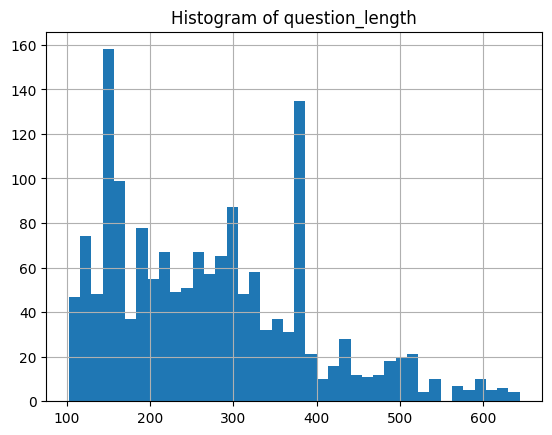

Five point summary of answer_length
 count    1600.000000
mean      877.372500
std       469.685544
min       101.000000
25%       519.750000
50%       786.000000
75%      1153.500000
max      2283.000000
Name: answer_length, dtype: float64


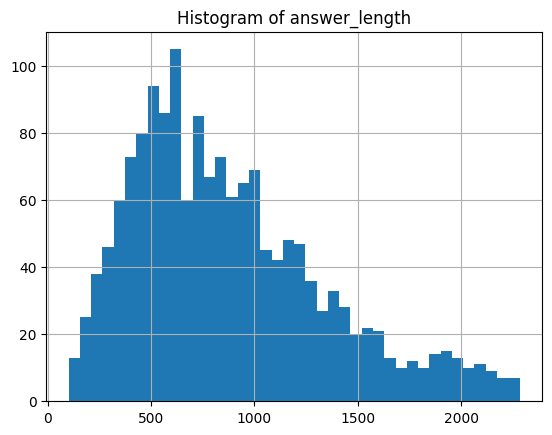

In [10]:
# Check distribution after removing outliers
for cols in ["question_length", "answer_length"]:
    df_no_outliers[cols].hist(bins=40)
    print(f"Five point summary of {cols}\n {df_no_outliers[cols].describe()}")
    plt.title(f"Histogram of {cols}")
    plt.show()

The data looks much better after dopping the unreasonable large length and small length records.

In [11]:
# Add unique id for each rows
df_no_outliers["id"] = df_no_outliers.index

#### Standardization

In [12]:
# import modules for text preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string

In [13]:
# this function removes stopwords from input text
    
def custom_standardization_fn(text):
    try:
        lowercase_string = text.lower()
    except AttributeError:
        lowercase_string=""
        return lowercase_string
    else:
        regex_punc = re.sub(
            f"[0-9{re.escape(string.punctuation)}]", lambda match: "" , lowercase_string)
        regex_clean = re.sub(
            f"[\\r\\t\\n]", lambda match: " " , regex_punc)
    
        stop_words = stopwords.words("english")
        tokenized_words = word_tokenize(regex_clean)
        stop_word_removed_tokens = [word for word in tokenized_words if word not in stop_words]
        stopword_removed_string = " ".join([word for word in tokenized_words if word not in stop_words])
        # lemmatize
        wnl = WordNetLemmatizer()
        return " ".join([wnl.lemmatize(words) for words in stop_word_removed_tokens])

In [14]:
df_filtered = df_no_outliers.copy()

In [15]:
df_no_outliers["questionText"] = df_no_outliers["questionText"].apply(custom_standardization_fn)
df_no_outliers["answerText"] = df_no_outliers["answerText"].apply(custom_standardization_fn)

In [16]:
# df_no_outliers = df_no_outliers.drop(df_no_outliers[df_no_outliers["answerText"].str.len() < 25].index)

In [17]:
df_no_outliers.head()

,Unnamed: 0,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split,question_length,answer_length,id
0,0,0,Can I change my feeling of being worthless to ...,im going thing feeling barely sleep nothing th...,https://counselchat.com/questions/can-i-change...,depression,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,everyone think youre worthless maybe need find...,1,2899,train,328,958,0
1,1,0,Can I change my feeling of being worthless to ...,im going thing feeling barely sleep nothing th...,https://counselchat.com/questions/can-i-change...,depression,"Robin Landwehr, DBH, LPCC, NCCMental Health in...",https://counselchat.com/therapists/robin-landw...,hello thank question seeking advice feeling wo...,1,3514,train,328,2076,1
2,2,0,Can I change my feeling of being worthless to ...,im going thing feeling barely sleep nothing th...,https://counselchat.com/questions/can-i-change...,depression,Lee KingI use an integrative approach to treat...,https://counselchat.com/therapists/lee-king,first thing id suggest getting sleep need impa...,0,5,train,328,299,2
3,3,0,Can I change my feeling of being worthless to ...,im going thing feeling barely sleep nothing th...,https://counselchat.com/questions/can-i-change...,depression,"Shauntai Davis-YearginPersonalized, private on...",https://counselchat.com/therapists/shauntai-da...,therapy essential feeling depressed worthless ...,0,31,train,328,841,3
4,4,0,Can I change my feeling of being worthless to ...,im going thing feeling barely sleep nothing th...,https://counselchat.com/questions/can-i-change...,depression,Jordan WhiteLicensed Social Worker at Oak Root...,https://counselchat.com/therapists/jordan-white,first want let know alone feeling always someo...,0,620,train,328,337,4


In [18]:
print(f"Number of records in the dataset: {df_no_outliers.shape[0]}")

Number of records in the dataset: 1600


**In order to keep cost low, a sample of about ~$500$ records is used in fine-tuning instead of all $3512$ records. A machine learning approah is used to sample the record instead od naive random sampling. `K-means` clustering method is used to create clusters of the records based on the similarilty of the mental health responses and then random samples are picked from each clusters. This ensures that the fine-tuning examples have a good mix of various different kind of mental health answers.**

#### K means Clustering

In [19]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sentence embedding is used to generate features at sentence level for the clustering task. Sentence Transformer model `all-MiniLM-L6-v2` is used to generate the sentence embeddings from the mental health responses. This ensures that the feature for clustering task represnt the semantic similarity based on the mental health responses at sentence level.

In [20]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

In [21]:
corpus = []
for row in df_no_outliers.iterrows():
    corpus.append(f'id:{row[1]["id"]}text:{row[1]["questionText"]}')
corpus_embeddings_kmeans = embedder.encode(corpus)

In k-means clustering finding the optimum value of `k` is critical to get good balance of clusters. `Within-cluster sum of squares(WCSS)` is a common metric used to identify a good value of `k`. WCSS is plotted against different values of `k` and `k value` near the elbow point is generally considered an optimum value of `k`.

In [22]:
# Perform kmean clustering for k starting from 1 to 50
num_clusters = 50
inertia = []
for k in range(1, num_clusters):
    clustering_model_kmean = KMeans(n_clusters=k)
    clustering_model_kmean.fit(corpus_embeddings_kmeans)
    # cluster_assignment = clustering_model.labels_
    inertia.append(clustering_model_kmean.inertia_)

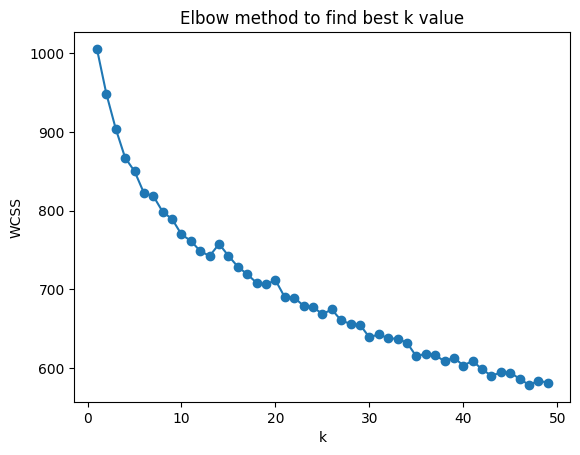

In [23]:
plt.plot(range(1, num_clusters), inertia, marker='o')
plt.title("Elbow method to find best k value")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.show()

`k=15` seems like the elbow point in the above curve

In [27]:
# Perform kmean clustering with k=13
num_clusters = 13
clustering_model_kmean = KMeans(n_clusters=num_clusters)
clustering_model_kmean.fit(corpus_embeddings_kmeans)
cluster_assignment_kmeans = clustering_model_kmean.labels_

Group the sentences tgether based on the clusters.

In [28]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment_kmeans):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

In [29]:
# Display number of responses in each clusters
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i + 1)
    print(len(cluster))


Cluster  1
117
Cluster  2
189
Cluster  3
167
Cluster  4
92
Cluster  5
94
Cluster  6
48
Cluster  7
187
Cluster  8
114
Cluster  9
46
Cluster  10
153
Cluster  11
94
Cluster  12
231
Cluster  13
68


From the $15$ clusters randomly choose responses to meet a maximum of $500$ records

In [30]:
MAX_RECORDS = 300
num_samples = (MAX_RECORDS//num_clusters) + 1

In [31]:
np.random.seed(42)
selected_responses = np.zeros((num_clusters,num_samples))
for i,each_cluster in enumerate(clustered_sentences):
    selected_responses[i] = (list(map(lambda x: x.split("text:")[0].split("id:")[-1], np.random.choice(each_cluster,num_samples,replace=False))))

In [32]:
df_response_ids = pd.DataFrame(selected_responses.astype("int").flatten(),columns=["id"])

In [33]:
print(f"Number of responses in resulting dataframe after selection: {df_response_ids.shape[0]}") 

Number of responses in resulting dataframe after selection: 312


Create a dataframe with the corresponding question and responses set with $506$ records

In [34]:
df_preprocesed = pd.merge(df_filtered,df_response_ids,how="inner",on="id").loc[0:,["questionText", "answerText"]]

In [35]:
# view few records
df_preprocesed.head()

,questionText,answerText
0,I'm going through some things with my feelings...,I first want to let you know that you are not ...
1,I'm going through some things with my feelings...,"Heck, sure thing, hun!Feelings of 'depression'..."
2,I'm going through some things with my feelings...,It sounds like you may be putting yourself las...
3,I'm going through some things with my feelings...,I'm glad you are interested in changing your f...
4,I'm going through some things with my feelings...,You have several things going on here. The sle...


Perform traning and validation split for use in fine-tuning

In [36]:
val_df = df_preprocesed.sample(frac=0.05, random_state=42)

In [37]:
train_df = df_preprocesed.drop(val_df.index)

In [38]:
train_df.shape, val_df.shape

((296, 2), (16, 2))

#### Create the Training and Validation Files in the OpenAI API format

In [39]:
training_data_file = "./datasets/training_file.jsonl"
validation_data_file = "./datasets/validation_file.jsonl"

In [40]:
# get the encoding for gpt-4o-mini-2024-07-18
encoding = tiktoken.encoding_for_model("gpt-4o-mini-2024-07-18")
print(f"Token encoding for gpt-4o-mini is : {encoding.name}")

Token encoding for gpt-4o-mini is : o200k_base


In [41]:
def create_jsonl_file(file_path,df):
    system_message = "You are an assistant that helps answer mental health question."
    system_message_tokens = len(encoding.encode(system_message))
    with jsonlines.open(file_path,mode="w") as writer:
        for row in df.iterrows():
            # context_tokens = len(encoding.encode(row[1]["Context"]))
            # assistant_tokens = len(encoding.encode(row[1]["Response"]))
            # if (system_message_tokens+context_tokens+assistant_tokens) < 500:
            message_dict = {
                "messages":[
                    {"role":"system","content":system_message},
                    {"role":"user","content":row[1]["questionText"]},
                    {"role": "assistant", "content":row[1]["answerText"]}
                ]
            }
            writer.write((message_dict))

In [42]:
create_jsonl_file(training_data_file, train_df)
create_jsonl_file(validation_data_file, val_df)

##### Token validation

`gpt-4o-mini-2024-07-18` will be used as foundational model for fine-tuning, so to get the correct token counts, the encoding corresponding to this model must be used.

In [43]:
MAX_TOKENS = 65536

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 1000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 5

##### Basic data check

In [44]:
def basic_checks(data_file):
    try:
        with open(data_file, "r", encoding="utf-8") as f:
            dataset = [json.loads(line) for line in f]

        print(f"Basic checks for file {data_file}:")
        print("Count of examples in dataset:", len(dataset))
        print("First example:")
        for message in dataset[0]["messages"]:
            print(message)
        return True
    except FileNotFoundError as e:
        print(f"File not found error occurred in file {data_file}: {e}")
        return False
    except json.JSONDecodeError as e:
        print(f"JSON decoding error occurred in file {data_file}: {e}")
        return False
    except Exception as e:
        print(f"An error occurred in file {data_file}: {e}")
        return False

In [45]:
if not basic_checks(training_data_file):
    print(f"Error in Trainingfile {training_data_file}")
if not basic_checks(validation_data_file):
    print(f"Error in Validation file {validation_data_file}")

Basic checks for file ./datasets/training_file.jsonl:
Count of examples in dataset: 296
First example:
{'role': 'system', 'content': 'You are an assistant that helps answer mental health question.'}
{'role': 'user', 'content': "I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.    I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.    How can I change my feeling of being worthless to everyone?"}
{'role': 'assistant', 'content': 'I first want to let you know that you are not alone in your feelings and there is always someone there to help. You can always change your feelings and change your way of thinking by being open to trying to change. You can always make yourself available to learning new things or volunteering so that you can make a purpose for yourself.'}
Basic checks for file ./datasets/validation_file.jsonl:
Count of ex

The training and validation files have passed the check for `jsonl` format 

In [46]:
def format_checks(dataset, filename):
    # Initialize a dictionary, used to track format errors
    format_errors = defaultdict(int)

    # Iterate over each example in the dataset
    for ex in dataset:
        # Check if the example is a dictionary, if not 
        # increment the corresponding error count
        if not isinstance(ex, dict):
            format_errors["data_type"] += 1
            continue

        # Check if the example has a "messages" key, 
        # if not increment the corresponding error count
        messages = ex.get("messages", None)
        if not messages:
            format_errors["missing_messages_list"] += 1
            continue

        # Iterate over each message in the messages list
        for message in messages:
            # Check if the message has "role" and "content" keys,
            # if not increment the corresponding error count
            if "role" not in message or "content" not in message:
                format_errors["message_missing_key"] += 1

            # Check if the message has any unrecognized keys,
            # if so increment the corresponding error count
            if any(k not in ("role", "content", "name", "function_call") for k in message):
                format_errors["message_unrecognized_key"] += 1

            # Check if the role of the message is one of the recognized
            # roles, if not increment the corresponding error count
            if message.get("role", None) not in (
                "system",
                "user",
                "assistant",
                "function",
            ):
                format_errors["unrecognized_role"] += 1

            # Check if the message has either content or a function call,
            # and if the content is a string, if not increment the
            # corresponding error count
            content = message.get("content", None)
            function_call = message.get("function_call", None)
            if (not content and not function_call) or not isinstance(content, str):
                format_errors["missing_content"] += 1

        # Check if there is at least one message with the role "assistant",
        # if not increment the corresponding error count
        if not any(message.get("role", None) == "assistant" for message in messages):
            format_errors["example_missing_assistant_message"] += 1

    # If there are any format errors, print them and return False
    if format_errors:
        print(f"Formatting errors found in file {filename}:")
        for k, v in format_errors.items():
            print(f"{k}: {v}")
        return False
    print(f"No formatting errors found in file {filename}")
    return True

In [47]:
# check example format are correct for training file
with open(training_data_file, "r", encoding="utf-8") as f:
    train_dataset = [json.loads(line) for line in f]
    if not format_checks(train_dataset, training_data_file):
        print(f"Error in training examples format validation for {training_data_file}")

No formatting errors found in file ./datasets/training_file.jsonl


In [48]:
# check example format are correct for validation file
with open(validation_data_file, "r", encoding="utf-8") as f:
    valid_dataset = [json.loads(line) for line in f]
    if not format_checks(valid_dataset, validation_data_file):
        print(f"Error in training examples format validation for {validation_data_file}")

No formatting errors found in file ./datasets/validation_file.jsonl


Fine tuning is billed by the `number of tokens` used in the training examples. Hence, it is always advisable to estimate the numbers tokens in the training examples and how many total tokens will be used in the fine-tuning. This will provide a rough estimate about the cost of the fine-tuning to avoid any surprises.

In [49]:
# Print the number of tokens in the messages
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

# print the number of tokens in the assistant messages
def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens


In [50]:
# Estimate the number of tokens that will be charged for during training
def estimate_tokens(dataset, assistant_tokens):
    # Set the initial number of epochs to the target epochs
    n_epochs = TARGET_EPOCHS
    
    # Get the number of examples in the dataset
    n_train_examples = len(dataset)

    # If the examples total is less than the minimum target
    # adjust the epochs to ensure we have enough examples for
    # training
    if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
        n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
    
    # If the  number of examples is more than the maximum target
    # adjust the  epochs to ensure we don't exceed the maximum 
    # for training
    elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
        n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

    # Calculate the total number of tokens in the dataset
    # n_billing_tokens_in_dataset = sum(min(MAX_TOKENS, length) for length in assistant_tokens)
    n_billing_tokens_in_dataset = sum(min(MAX_TOKENS, length) for length in assistant_tokens)

    # Print the total token count that will be charged during training
    print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")

    # Print the default number of epochs for training
    print(f"You will train for {n_epochs} epochs on this dataset")

    # Print the total number of tokens that will be charged during training
    print(f"You will be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

    # If the total token count exceeds the maximum tokens, print a warning 
    # if n_billing_tokens_in_dataset > MAX_TOKENS:
    #     print(f"WARNING: Your dataset contains examples longer than 4K tokens by {n_billing_tokens_in_dataset - MAX_TOKENS} tokens.")
    #     print("You will be charged for the full length of these examples during training, but only the first 4K tokens will be used for training.")
    return n_billing_tokens_in_dataset

In [51]:
with open(training_data_file, "r", encoding="utf-8") as f:
    train_dataset = [json.loads(line) for line in f]
with open(validation_data_file, "r", encoding="utf-8") as f:
    valid_dataset = [json.loads(line) for line in f]

In [52]:
total_tokens = []
assistant_tokens = []
for example in train_dataset:
    messages = example.get("messages", {})
    total_tokens.append(num_tokens_from_messages(messages))
    assistant_tokens.append(num_assistant_tokens_from_messages(messages))

In [53]:
tokens_used_in_training = estimate_tokens(train_dataset, total_tokens)

Dataset has ~77614 tokens that will be charged for during training
You will train for 3 epochs on this dataset
You will be charged for ~232842 tokens


In [54]:
print(f"Estimated Cost: $ {(3/1000000)*tokens_used_in_training*TARGET_EPOCHS}")

Estimated Cost: $ 0.698526


OpenAI doesnot charge for validation tokens, so only training tokens are charged. Current pricing is \$3 per 1M tokens. For the above training dataset the estimated cost is `$0.7`

### 2. Upload training file to Open AI

Open AI requires the training and validation file to be uploaded in OpenAI file storage for training.

In [55]:
# get api key from file
with open("../../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]
os.environ["OPENAI_API_KEY"] = api_key

In [56]:
# Upload training file
from openai import OpenAI
client = OpenAI()

response = client.files.create(
  file=open(training_data_file, "rb"),
  purpose="fine-tune"
)

In [57]:
print("Uploaded file details\n",response)

Uploaded file details
 FileObject(id='file-EAbGaRrrcR6Us5n67fw3cN', bytes=393433, created_at=1738630964, filename='training_file.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [58]:
# upload validation file
validation_file_response = client.files.create(
  file=open(validation_data_file, "rb"),
  purpose="fine-tune"
)
print("Uploaded file details\n",validation_file_response)

Uploaded file details
 FileObject(id='file-P6gV7ibG3H71QGDZKLVNbA', bytes=22048, created_at=1738631012, filename='validation_file.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


### 3. Create and start Fine tuning job

In [59]:
ft_job = client.fine_tuning.jobs.create(
    training_file="file-EAbGaRrrcR6Us5n67fw3cN",
    validation_file="file-P6gV7ibG3H71QGDZKLVNbA",
    model="gpt-4o-mini-2024-07-18",
    suffix="mental-hlth-20250203",
    hyperparameters={
        "n_epochs":3
    },
)

print("Finetuning job details:\n", ft_job)

Finetuning job details:
 FineTuningJob(id='ftjob-6b1KfEYfMDC9x1QHCp5KfxIA', created_at=1738631057, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=3), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-i0HGnyzXyYOGEdOd7p2dDDri', result_files=[], seed=1329404520, status='validating_files', trained_tokens=None, training_file='file-EAbGaRrrcR6Us5n67fw3cN', validation_file='file-P6gV7ibG3H71QGDZKLVNbA', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=3)), type='supervised'), user_provided_suffix='mental-hlth-20250203')


In [60]:
# Retrieve the state of a fine-tune
start_time = time.time()
while True:
    job = client.fine_tuning.jobs.retrieve("ftjob-6b1KfEYfMDC9x1QHCp5KfxIA")
    print(job.id, job.status)
    if job.status in ["succeeded","failed","cancelled"]:
        print(f"Job Status: {job.status}")
        print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
        break
    time.sleep(60)

ftjob-6b1KfEYfMDC9x1QHCp5KfxIA validating_files
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA validating_files
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6b1KfEYfMDC9x1QHCp5KfxIA running
ftjob-6

Open AI fine tuning job stores the fine-tuning metrics in a result file. The file-id of the resut file can be reference by retriveing the job details in `result_files` attribute.

### 4. Evaluate Metrics

In [61]:
#retrive the result file id and model name of the model
result = client.fine_tuning.jobs.retrieve("ftjob-6b1KfEYfMDC9x1QHCp5KfxIA")
print(f"Model id: {result.fine_tuned_model}\nResult file id: {result.result_files}")

Model id: ft:gpt-4o-mini-2024-07-18:personal:mental-hlth-20250203:Ax2BrLIR
Result file id: ['file-93TnAw74bNt7yZ4gaeWwBc']


In [62]:
# Retrive file content from the fine tuning job results
# from openai import OpenAI
# client = OpenAI()

ft_results = client.files.content(result.result_files[0])

The results are `base-64` encoded, so it needs to be decoded for use and can be downloaded as csv.

In [63]:
import base64

string_bytes = base64.b64decode(ft_results.content)
result_string = string_bytes.decode("ascii")

with open("./fine-tuning-results.csv","w") as outfile:
    outfile.write(result_string)


Using pandas to read the reslts csv file and plotting the training and validation loss curves

In [13]:
import pandas as pd
from matplotlib import pyplot as plt

In [14]:
df = pd.read_csv("./fine-tuning-results.csv")

In [15]:
df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,train_mean_reward,full_validation_mean_reward
0,1,2.65326,0.43191,NaN,NaN,NaN,NaN
1,2,2.93224,0.42446,NaN,NaN,NaN,NaN
2,3,2.39931,0.46392,NaN,NaN,NaN,NaN
3,4,3.19634,0.42063,NaN,NaN,NaN,NaN
4,5,2.60203,0.51955,NaN,NaN,NaN,NaN


Loss Metric is use to evaluate the training and validation performance. Training loss is always high in the starting but it gradually reduces towards zero as the model trains on more data in every step of epochs. 

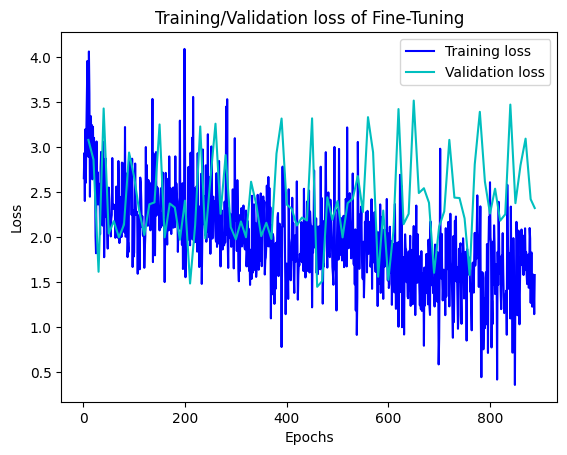

In [21]:
# Plot the training loss and validation loss
plt.plot(df["step"], df["train_loss"], 'b-', label='Training loss')
plt.plot(df[df["valid_loss"].notna()]["step"], df[df["valid_loss"].notna()]["valid_loss"], 'c-', label='Validation loss')
plt.title('Training/Validation loss of Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


As expected the `training loss` is high at the staring and decreasing towards a stable value over time. We see some difference between the `validation loss` and `training loss` towards the end which shows that training loss is decreasing but validation loss remains stable which indicates `some degree of overfitting`. Furthermore, both the training loss and validation loss have fluctuation with every batch of training which is fine because it shows the loss is varying with the varying sets of data in every batch and the model is not too much overfitted. 

Mean token acuracy metric ia a measure of how accurately the model is able to predict the next token in sequencen on an average. 

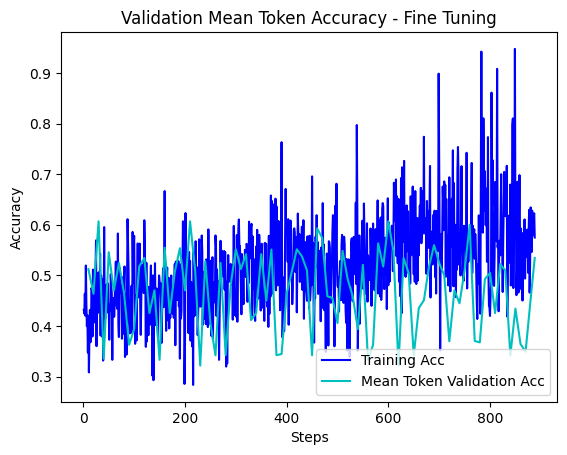

In [22]:
# plot the Mean Token accuracy
plt.plot(df["step"], df["train_accuracy"], 'b-', label='Training Acc')
plt.plot(df[df["valid_mean_token_accuracy"].notna()]["step"], df[df["valid_mean_token_accuracy"].notna()]["valid_mean_token_accuracy"], 'c-', label='Mean Token Validation Acc')
plt.title('Validation Mean Token Accuracy - Fine Tuning')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

The maximum `mean token accuracy` reached is $0.6$ for the validation file, whereas the training accuracy recahed more than $0.9$ by the end of training epochs. This shows that model is suffering from some overfitting because the trainig accuracy increased ver time but the validation mean token accuracy remains appproximately same.

### 45. Testing the fine tuned model

Prompt 1: Feeling hopeless and anxious, how can I help myself

In [26]:
# get api key from file
with open("../../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]
os.environ["OPENAI_API_KEY"] = api_key

In [27]:
from openai import OpenAI
client = OpenAI()

In [30]:
messages=[
        {
            "role": "system", 
            "content": f"You are an assistant that helps answer mental health question."
        },
        {
            "role": "user", 
            "content": f"Feeling hopeless and anxious, how can I help myself"
        }
    ]

In [ ]:
chat_response_1_std = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    max_completion_tokens=100
)
print(f"Response from GPT 4o mini without fine-tuning:\n {chat_response_1_std.choices[0].message.content}")

In [31]:
chat_response_1_fine_tuned = client.chat.completions.create(
    model="ft:gpt-4o-mini-2024-07-18:personal:mental-hlth-20250203:Ax2BrLIR",
    messages=messages
)
print(f"Response from fine-tuned model:\n {chat_response_1_fine_tuned.choices[0].message.content}")

Response from fine-tuned model:
 Feeling hopeless is indicative of depressive symptoms. Some self-help strategies for depression include:Increasing pleasant activity: having a daily schedule that includes activities that are helpful to you and that you find enjoyable or pleasurableEngaging in social activity: connecting with friends and family, or a group of people who share similar interests. Increasing interpersonal engagement can help to mitigate feelings of sadnessIncorporating exercise into your routine: exercise is a natural mood booster, and can also serve as a healthy way to cope with stress. Intentional walking can be helpful in alleviating depressive symptomsPracticing self-care: physical self-care (getting enough sleep, eating nutritious food, etc.) and emotional and spiritual self-care (engaging in the activities and hobbies that you enjoy, etc.) are critical components of improving one’s mood.Challenging negative thinking: cognitive distortions such as catastrophizing, ove

Prompt 2: Feeling like hurting someone, need help

In [32]:
messages=[
        {
            "role": "system", 
            "content": f"You are an assistant that helps answer mental health question."
        },
        {
            "role": "user", 
            "content": f"Feeling like hurting someone, need help"
        }
    ]

In [33]:
chat_response_2_fine_tuned = client.chat.completions.create(
    model="ft:gpt-4o-mini-2024-07-18:personal:mental-hlth-20250203:Ax2BrLIR",
    messages=messages
)
print(f"Response from fine-tuned model:\n {chat_response_2_fine_tuned.choices[0].message.content}")

Response from fine-tuned model:
 Yes, ask for help right away. Call your local crisis center, or the national hotline at 1-800-273-8255.


The resonses from the fine-tuned model for mental health questions are very promising. The fine-tuned model is suggesting remediation strategies and helpful steps to support mental health situations whenever reasonable to do so. It is interesting to notice that the fine-tuned model directly mentions to `call crisis hotline` instead of making up some answer in dire situations as in case of prompt 2. Overall the fine-tuned model is providing better mental health aligned reponse than general foundational LLM.